In [24]:
import torch
import yaml
import os
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import makedirs
from scene import Scene
from gaussian_renderer import render
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import GaussianModel
from arguments import ModelParams, PipelineParams, OptimizationParams, GroupParams

In [2]:
def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

In [88]:
config = 'config/org_ssim_0.5_tandt_train.yaml'
iteration = 30_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)

config_name = os.path.splitext(os.path.basename(config))[0]
lp.model_path = os.path.join("./output/", config_name)

In [89]:
with torch.no_grad():
    gaussians = GaussianModel(lp.sh_degree)
    scene = Scene(lp, gaussians, load_iteration=iteration, shuffle=False)
    views = scene.getTestCameras()  # getTrainCameras, getTestCameras
    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

Loading trained model at iteration 30000
Reading camera 301/301
Loading Training Cameras
Loading Test Cameras


In [96]:
idx = 11
img_opt = 'points'  # 'depths', 'points'

In [97]:
with torch.no_grad():
    view = views[idx]
    render_pkg = render(view, gaussians, pp, background)
image, viewspace_point_tensor, visibility_filter, radii, geometry = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"], render_pkg["geometry"]
image = image.cpu().numpy().transpose(1,2,0)
H, W, _ = image.shape
# geometry protocol: means2D(2), depths, cov(3), opacity, rgb(3), 10 dim in total
geometry = geometry.cpu().numpy()
visibility_filter = visibility_filter.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


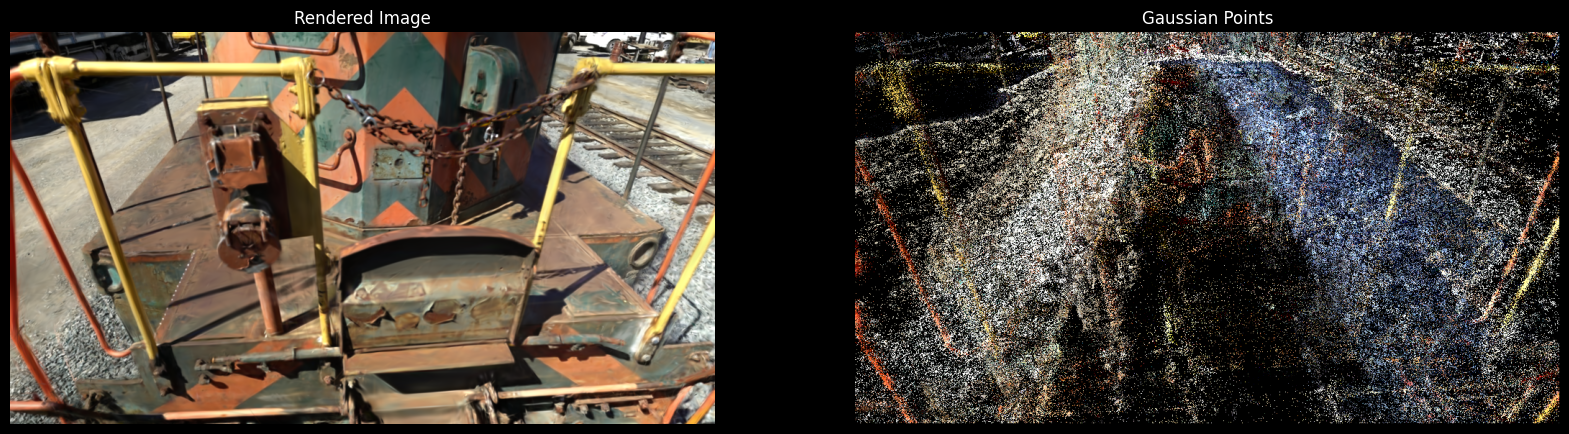

In [103]:
gaussian_centers = np.zeros_like(image)
gaussian_depths = np.zeros([H, W])
mask = visibility_filter & (geometry[:, 1] >= 0) & (geometry[:, 1] <= H-1) & (geometry[:, 0] >= 0) & (geometry[:, 0] <= W-1)
masked_geom = geometry[mask]
# colors = masked_geom[:,7:10] * masked_geom[:,6:7]  # opacity * rgb
colors = masked_geom[:,7:10]
gaussian_centers[masked_geom[:,1].astype(np.int64), masked_geom[:,0].astype(np.int64), :] = colors
gaussian_depths[masked_geom[:,1].astype(np.int64), masked_geom[:,0].astype(np.int64)] = masked_geom[:,2]

plt.figure(figsize=(20, 30))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f'Rendered Image')
plt.axis('off')

plt.subplot(1, 2, 2)
if img_opt == 'points':
    plt.imshow(gaussian_centers)
    plt.title(f'Gaussian Points')
elif img_opt == 'depths':
    plt.imshow(gaussian_depths, cmap='rainbow')
    plt.title(f'Gaussian Depths')
plt.axis('off')
plt.show()